<a href="https://colab.research.google.com/github/Kienknu/Kienknu/blob/main/K_SOA_Toluene.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Toluene**

- n=1>>0.34%
- n=2>>3.60%
- n=3>>15.78%
- n=4>>30.02%
- n=5, f=3, cutoff=0.7>>38.77% (20min)
- n=5, f=3, cutoff=0.6>>43.40 (45min)
- n=5, f=3, cutoff=0.5>>44.77%(90min)

CHON compounds
- n=1>>0.34%
- n=2>>3.95%
- n=3>>16.98%
- n=4>>31.39%
- n=5, f=3, cutoff=0.7>>38.77% (20min)
- n=5, f=3, cutoff=0.6>>43.40 (45min)
- n=5, f=3, cutoff=0.5>>44.77%(90min)

In [1]:
!pip install rdkit
!pip install molmass
!pip install pyscf
!pip install geometric

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.0/386.0 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for geometric: filename=geometric-1.1-py3-none-any.whl size=402087 sha256=323ba6068e136aa5acdf4059f1c5c6b50e4ae8ef30ff2d5d0620eeee5c0e83f1
  Stored in directory: /root/.cache/pip/wheels/c5/77/0c/96a54539fe0560749fdbe283f92582d09bddb212856407a4cb
Successfully built geometric


In [2]:
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, rdChemReactions
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import display
from rdkit.Chem import Descriptors
import pandas as pd
import requests
import io
from molmass import Formula
import matplotlib.pyplot as plt
from rdkit.ML.Cluster import Butina
from rdkit.Chem import rdMolDescriptors
from rdkit import Chem, DataStructs
import numpy as np
from pyscf import gto, scf

**1. Functions definition**

In [3]:
#--- RDKit Fingerprints----#
def cluster_and_filter(mols, cutoff):
    mols = [mol for mol in mols if mol is not None]
    if not mols:
        return []
    # Genete RDKit Fingerprints
    fps = [AllChem.RDKFingerprint(mol) for mol in mols]

    num_mols = len(mols)
    dists = []
    for i in range(1, num_mols):
        sims = DataStructs.BulkTanimotoSimilarity(fps[i], fps[:i])
        dists.extend([1 - x for x in sims])

    clusters = Butina.ClusterData(dists, num_mols, cutoff, isDistData=True)
    unique_mols = [mols[cluster[0]] for cluster in clusters]
    return unique_mols

#--- PubChem checking---#
def check_pubchem_by_smiles(smiles):
    """
    Checks if a compound with the given SMILES exists in PubChem.

    Args:
        smiles (str): The SMILES string of the compound to check.

    Returns:
        tuple: (bool is_found, str or None cid_value).
               is_found is True if a CID (0 or positive) is returned, False otherwise.
               cid_value is the CID as a string if found, None otherwise.
    """
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/{requests.utils.quote(smiles)}/cids/JSON"

    try:
        response = requests.get(url)
        response.raise_for_status()

        data = response.json()

        if 'IdentifierList' in data and data['IdentifierList']['CID']:
            cid = data['IdentifierList']['CID'][0]
            return True, str(cid)
        else:
            return False, None

    except requests.exceptions.RequestException as e:
        #print(f"Error checking PubChem for {smiles}: {e}")
        return False, None
    except ValueError:
        #print(f"Invalid JSON response from PubChem for {smiles}.")
        return False, None

# Mass calculation from data
def calculate_monoisotopic_masses(formula):
    try:
        f = Formula(formula)
        mono_mass = f.isotope.mass  # Monoisotopic mass
        mh_mass = mono_mass - 1.007825  # [M-H]
        mph_mass = mono_mass + 1.007825  # [M+H]
        return mono_mass, mh_mass, mph_mass
    except Exception as e:
        print(f"Error with formula {formula}: {e}")
        return None, None, None

# Trace all pathways
def trace_reaction_path_all(target_product_smiles, reaction_history, current_path=None, all_paths=None, visited_paths=None):
    """Traces ALL unique reaction pathways through reaction_history."""

    if current_path is None:
        current_path = []
    if all_paths is None:
        all_paths = []
    if visited_paths is None:
        visited_paths = set()

    # Find all steps in reaction_history that produce the target_product_smiles
    producing_steps = [(i, step) for i, step in enumerate(reaction_history) if step[2] == target_product_smiles]

    if not producing_steps:
        if current_path:
            # Create a tuple of tuples to represent the pathway for set checking
            path_tuple = tuple(current_path)
            if path_tuple not in visited_paths:
                all_paths.append(list(reversed(current_path)))
                visited_paths.add(path_tuple)
        return all_paths

    for original_index, step in producing_steps:
        reactant, rxn_index, product, is_match = step

        # Create a new path by adding the current step
        new_step = (reactant, rxn_index, product, is_match)
        new_path = current_path + [new_step]

        # Recursively trace the reactant
        trace_reaction_path_all(reactant, reaction_history, current_path=new_path, all_paths=all_paths, visited_paths=visited_paths)

    return all_paths

**2. Experimental data with mass calculation**

In [4]:
# online file
url = "https://docs.google.com/spreadsheets/d/1pBx8tnFjT5FHe-KaPjAOxNMYgYAr6ie-/edit?usp=sharing&ouid=105784435570061437896&rtpof=true&sd=true"

# spreadsheet ID
spreadsheet_id = url.split("/d/")[1].split("/")[0]

# Excel export URL
excel_export_url = f"https://docs.google.com/spreadsheets/d/{spreadsheet_id}/export?format=xlsx"

# Download
response = requests.get(excel_export_url)
response.raise_for_status()

# Read
exp_data = pd.read_excel(io.BytesIO(response.content), sheet_name='Tol_NH3_CHON', engine='openpyxl')

# Add new column for Monoisotopic mass:
exp_data[['Neutral_Mass', '[M-H]', '[M+H]']] = exp_data['Formula'].apply(
    lambda x: pd.Series(calculate_monoisotopic_masses(x))
)

exp_data.head()

,Class,DBE,Neutral_DBE,Formula,Exp_m/z,neutral_mass,pos_mass,Mono_Abund,Total_Abund,Calc_m/z,...,#O,#S,H/C,N/C,O/C,S/C,Osc,Neutral_Mass,[M-H],[M+H]
0,NO4,5.5,5,C7H7NO4,168.030370,169.038195,170.045995,84906561.99,91434808.22,168.030231,...,4,0,1.0000,0.1429,0.5714,0,-0.4286,169.037508,168.029683,170.045333
1,NO4,5.5,5,C6H5NO4,154.014731,155.022556,156.030356,61072644.65,64970660.40,154.014581,...,4,0,0.8333,0.1667,0.6667,0,-0.1666,155.021858,154.014033,156.029683
2,N2O6,6.5,6,C7H6N2O6,213.015519,214.023344,215.031144,15825731.09,17159318.81,213.015309,...,6,0,0.8571,0.2857,0.8571,0,0.0000,214.022586,213.014761,215.030411
3,N2O10,3.5,3,C7H12N2O10,283.042127,284.049952,285.057752,13027120.30,14047110.36,283.041918,...,10,0,1.7143,0.2857,1.4286,0,-0.2857,284.049195,283.041370,285.057020
4,N3O13,3.5,3,C7H13N3O13,346.037477,347.045302,348.053102,9003501.35,9746036.59,346.037561,...,13,0,1.8571,0.4286,1.8571,0,0.0000,347.044837,346.037012,348.052662


**3. Simulation**

In [5]:
reaction_rules = [
    #-----------------------------------------------selected group-----------------------------------------#

    AllChem.ReactionFromSmarts('[cH:1]>>[c:1][OH]'),                                                   # n=3>>0%-top3(round2),n=1>>0.69%(selected)-0
    AllChem.ReactionFromSmarts('[cH:1]>>[c:1][N+](=O)[O-]'),                                           # n=3>>1.20%-top3(round2),n=1>>4.63%(selected)-1
    AllChem.ReactionFromSmarts('[cH:1]>>[c:1][N](=O)'),                                                # n=3>>1.20%-top3(round2),n=1>>4.80%(selected)-2

    AllChem.ReactionFromSmarts('[cH:1]>>[c:1]OO'),                                                     # n=3>>1.89%-top3(round2),n=1>>5.15%(selected)-3
    # Toluene to benzaldehyde (Side-chain oxidation)
    AllChem.ReactionFromSmarts('[c:1][CH3:2]>>[c:1][C:2]=O'),                                          # n=3>>2.23%-top3(round2),n=1>>6.00%(selected)-4

    AllChem.ReactionFromSmarts('[CH3:1]>>[CH2:1]OO'),                                                  # n=3>>2.23%-top3(round2),n=1>>7.03%(selected)-5
    AllChem.ReactionFromSmarts('[cH:1]>>[cH:1][O][N+](=O)[O-]'),                                       # n=3>>3.43%-top3(round2),n=1>>9.78%(selected)-6
    #Friedel-Crafts methylation
    AllChem.ReactionFromSmarts('[c:1][cH:2][cH:3]>>[c:1][c:2]([CH3])[cH:3]'),                          # n=3>>4.12% -top3(round2),n=1>>10.81%(selected)-7

    # Ring opening
    AllChem.ReactionFromSmarts('[c:1]1[c:2][c:3][c:4][c:5][c:6]1>>[C:1]=[C:2][C:3]=[C:4][C:5]=[C:6]'), #n=3>>3.95%(selected)-8
    AllChem.ReactionFromSmarts('[c:1]1[c:2][c:3][c:4][c:5][c:6]1>>[C:1]=[C:2][C:3]1[C:4][C:5][C:6]1'), #n=3>>4.12%(selected)-top3(round2),n=1>>10.46%-9
    AllChem.ReactionFromSmarts('[c:1]1[c:2][c:3][c:4][c:5][c:6]1>>[C:1]1[C:2]=[C:3][C:4][C:5][C:6]1'), #n=3>>-10
    #-----Nitration: NO₂ group addition----#
    AllChem.ReactionFromSmarts('[CH3:1]>>[CH2:1][N+](=O)[O-]'),                                        #n=1>>4.12%(selected)-11
    AllChem.ReactionFromSmarts('[C:1][*]>>[C:1][N+](=O)[O-]'),                                         #n=1>>11.84%(selected,sum=11.84%)+-12

    #-----Nitrosation: NO group addition----#
    AllChem.ReactionFromSmarts('[C:1][*]>>[C:1][N](=O)'),             #      n=1>>12.69%(selected,sum=12.69%)+-13

    #-----Carboxylation: COOH group addition----#
    AllChem.ReactionFromSmarts('[CH3:1]>>[C:1]C(=O)O'),               #      n=1>>15.09%(selected)-14
    AllChem.ReactionFromSmarts('[C:1][*]>>[C:1]C(=O)O'),              #      n=1>>18.01%(selected,sum=18.01%)+-15

    #-----Carbonylation: CO group addition----#
    AllChem.ReactionFromSmarts('[C:1][*]>>[C:1]C(=O)'),               #      n=1>>18.35%(selected,sum=18.35%)+-16

    #-----Amination: NH2 addition----#
    AllChem.ReactionFromSmarts('[C:1][*]>>[C:1][NH2]'),                #      n=1>>18.52%(selected,sum=18.52%)+-17

    #-----Epoxidation / Internal Rearrangement----#
    AllChem.ReactionFromSmarts('[C:1]=[C:2]>>[C:1]C(=O)C[C:2]'),          #    n=1>>18.70%(selected)+-18

    #-----Oligomerization----#
    AllChem.ReactionFromSmarts('[C:1][C:2]>>[C:1][CH]=[CH][C:2]'),        #    n=1>>19.38%(selected)+-19
    #Branched dimerization
    AllChem.ReactionFromSmarts('[C:1][C:2]>>[C:1][CH][CH2][C:2]'),          # n=3>>12.18%,selected)(New)-20

    # ----Addition of NO----#
    AllChem.ReactionFromSmarts('[C:1]=[C:2]>>[C:1][NO]-[C:2]'),            # n=1>>19.55%(selected)+-21

    # 24.Ozonolysis
    AllChem.ReactionFromSmarts('[C:1]=[C:2]>>[C:1](=O).[C:2](=O)'),            #n=1>>19.73%(selected)+-22

    #-----Nitrate ester formation----#
    AllChem.ReactionFromSmarts('[C:1][*]>>[C:1][O][N+](=O)[O-]'),         #n=1>>19.90%(selected,sum=19.90%)+-23

    # OH radical substitution on methyl
    AllChem.ReactionFromSmarts('[CH3:1]>>[OH:1]'),                             #n=3>>16.98%(selected)(New)24

    #--------------------------------------------From MCM web--------------------------------------------------#
    #AllChem.ReactionFromSmarts('Cc1ccccc1>>[O]OCc1ccccc1'),         # Toluene>>C6H5CH2O2(1)                      # n=3>>4.12 -top3(round2),n=1>>10.81%-
    AllChem.ReactionFromSmarts('Cc1ccccc1>>[O]OC1C=CC2(C)OOC1C2O'),  # Toluene>>TLBIPERO2(2)                      # n=3>>4.12 -top3(round2),n=1>>11.32%(selected)-25
    #AllChem.ReactionFromSmarts('Cc1ccccc1>>O=CC1OC1C=CC(=O)C'),     # Toluene>>TLEPOXMUC(3)                      # n=3>>4.12 -top3(round2),n=1>>11.32%-
    #AllChem.ReactionFromSmarts('Cc1ccccc1>>Cc1ccccc1O'),            # Toluene>>CRESOL(4)                         # n=3>>4.12 -top3(round2),n=1>>11.32%-

    #AllChem.ReactionFromSmarts('[O]OCc1ccccc1>>[O]Cc1ccccc1'),      # (1)C6H5CH2O2>>C6H5CH2O                     # n=3>>4.12 -top3(round2),n=1>>11.32%-
    #AllChem.ReactionFromSmarts('[O]OCc1ccccc1>>O=N(=O)OCc1ccccc1'), # (1)C6H5CH2O2>>C6H5CH2NO3                   # n=3>>4.12 -top3(round2),n=1>>11.32%-
    #AllChem.ReactionFromSmarts('[O]OCc1ccccc1>>OOCc1ccccc1'),       # (1)C6H5CH2O2>>C6H5CH2OOH                   # n=3>>4.12 -top3(round2),n=1>>11.32%-
    #AllChem.ReactionFromSmarts('[O]OCc1ccccc1>>O=Cc1ccccc1'),       # (1)C6H5CH2O2>>BENZAL                       # n=3>>4.12 -top3(round2),n=1>>11.32%-
    #AllChem.ReactionFromSmarts('[O]OCc1ccccc1>>OCc1ccccc1'),        # (1)C6H5CH2O2>>C6H5CH2OH                    # n=3>>4.12 -top3(round2),n=1>>11.32%-

    #AllChem.ReactionFromSmarts('[O]OC1C=CC2(C)OOC1C2O>>[O]C1C=CC2(C)OOC1C2O'),      # (2)TLBIPERO2>>TLBIPERO     # n=3>>4.12-top3(round2),n=1>>11.32%-
    AllChem.ReactionFromSmarts('[O]OC1C=CC2(C)OOC1C2O>>O=N(=O)OC1C=CC2(C)OOC1C2O'),  # (2)TLBIPERO2>>TLBIPERNO3   # n=3>>4.46-top3(round2),n=1>>13.04%(selected)-26
    #AllChem.ReactionFromSmarts('[O]OC1C=CC2(C)OOC1C2O>>OOC1C=CC2(C)OOC1C2O'),       # (2)TLBIPERO2>>TLBIPEROOH   # n=3>>4.46-top3(round2),n=1>>13.04%-
    #AllChem.ReactionFromSmarts('[O]OC1C=CC2(C)OOC1C2O>>OC1C=CC2(C)OOC1C2O'),        # (2)TLBIPERO2>>TLBIPER2OH   # n=3>>4.46-top3(round2),n=1>>13.04%-
    #AllChem.ReactionFromSmarts('[O]OC1C=CC2(C)OOC1C2O>>O=C1C=CC2(C)OOC1C2O'),       # (2)TLBIPERO2>>TLOBIPEROH   # n=3>>4.46-top3(round2),n=1>>13.04%-

    #AllChem.ReactionFromSmarts('O=CC1OC1C=CC(=O)C>>O=CC1OC1C=O.CC(=O)O[O]'),        # (3) TLEPOXMUC>>EPXC4DIAL.CH3CO3   # n=3>>4.46-top3(round2),n=1>>13.04%-
    #AllChem.ReactionFromSmarts('O=CC1OC1C=CC(=O)C>>[O]OC(C=O)C=CC(=O)C'),           # (3) TLEPOXMUC>>C615CO2O2          # n=3>>4.46-top3(round2),n=1>>13.04%-
    #AllChem.ReactionFromSmarts('O=CC1OC1C=CC(=O)C>>CC(=O)C=CC1OC1C(=O)O[O]'),       # (3) TLEPOXMUC>>TLEMUCCO3          # n=3>>4.46-top3(round2),n=1>>13.04%-
    #AllChem.ReactionFromSmarts('O=CC1OC1C=CC(=O)C>>[O]OC(C(=O)C)C(O)C1OC1C=O'),     # (3) TLEPOXMUC>>TLEMUCO2           # n=3>>4.46-top3(round2),n=1>>13.04%-
    #AllChem.ReactionFromSmarts('O=CC1OC1C=CC(=O)C>>O=CC1OC1C=O.[O-][O+]=CC(=O)C'),  # (3) TLEPOXMUC>>EPXC4DIAL.MGLOOB   # n=3>>4.46-top3(round2),n=1>>13.04%-

    #AllChem.ReactionFromSmarts('Cc1ccccc1O>>Cc1ccccc1[O]'),                    # (4)CRESOL>>TOL1O       # n=3>>4.46-top3(round2),n=1>>13.04%-
    AllChem.ReactionFromSmarts('Cc1ccccc1O>>[O]OC1(O)C=CC2(C)OOC1C2O'),         # (4)CRESOL>>CRESO2      # n=3>>4.46-top3(round2),n=1>>13.55%(selected)-27
    #AllChem.ReactionFromSmarts('Cc1ccccc1O>>Oc1c(C)cccc1O'),                   # (4)CRESOL>>MCATECHOL   # n=3>>4.46-top3(round2),n=1>>13.55%-
    AllChem.ReactionFromSmarts('Cc1ccccc1O>>[O]OC1(O)C=CC2(C)OOC1C2ON(=O)=O'),  # (4)CRESOL>>NCRESO2     # n=3>>4.46-top3(round2),n=1>>14.07%(selected)-28

    #-----------------------------------Literature------------------------------------------#
    #AllChem.ReactionFromSmarts('CC1=CC=CC=C1>>CC1=C[C]C(O)C=C1'),              # OH radical addition    # n=3>>4.46-top3(round2),n=1>>14.07%-
    #AllChem.ReactionFromSmarts('CC1=C[C]CC=C1>>CC1=CC([N+]([O-])=O)=CC=C1'),   # Nitration              # n=3>>4.46-top3(round2),n=1>>14.07%-
    #AllChem.ReactionFromSmarts('CC1=C[C]CC=C1>>CC1=CC(N=O)=CC=C1'),            # Nitrosation            # n=3>>4.46-top3(round2),n=1>>14.07%-
    #AllChem.ReactionFromSmarts('CC1=C[C]CC=C1>>CC1=CC=CC=C1'),                 # Dehydration            # n=3>>4.46-top3(round2),n=1>>14.07%-
    #AllChem.ReactionFromSmarts('CC1=C[C]CC=C1>>CC1=CC(O[O])CC=C1'),            # Peroxidation           # n=3>>4.46-top3(round2),n=1>>14.07%-
    #AllChem.ReactionFromSmarts('CC1=CC(C)CC=C1>>CC1=CC([O])CC=C1'),            # Reduction(oxyradical)  # n=3>>4.46-top3(round2),n=1>>14.07%-
    #AllChem.ReactionFromSmarts('CC1=CC(C)CC=C1>>CC1=CC(O[N+]([O-])=O)=CC=C1'), # Nitration              # n=3>>4.46-top3(round2),n=1>>14.07%-

    #AllChem.ReactionFromSmarts('CC1(OO2)C(O)C2C=CC1[O]>>O=C/C=C/C=O.O=CC(C)=O'), #Selfdegradation #n=1>>19.90%-
    #AllChem.ReactionFromSmarts('O=C/C=C/C=O>>O=C(O)/C=C/C(O)=O'),                #Oxidation-      #n=1>>19.90%-
    #AllChem.ReactionFromSmarts('O=C/C=C/C=O>>O=C(N)/C=C/C(N)=O'),                #Amidation-      #n=1>>19.90%-

    # -----------------------------------------Tested rules-------------------------------------------------#
    #AllChem.ReactionFromSmarts('[cH:1]>>[c:1]'),                              # n=3>>0%-top3(round2),n=1>>0%-
    #AllChem.ReactionFromSmarts('[cH:1]>>[c:1][NH2]'),                         # n=3>>1.20%-top3(round2),n=1>>4.80%-
    #AllChem.ReactionFromSmarts('[c:1][CH:2]=O>>[c:1][C:2](=O)[OH]'),          # n=3>>2.23%-top3(round2),n=1>>6.00%-

    #AllChem.ReactionFromSmarts('[c:1][CH2:2][OH]>>[c:1][CHO:2]'),       # n=3>>4.12 -top3(round2),n=1>>10.81%-
    #AllChem.ReactionFromSmarts('[cH:1][CH3:2]>>[cH:1][CH2:2][OH]'),     # n=3>>4.12 -top3(round2),n=1>>10.81%-
    #AllChem.ReactionFromSmarts('[cH:1]OO>>[cH:1][O][NO2]'),             # n=3>>4.12 -top3(round2),n=1>>10.81%-
    #AllChem.ReactionFromSmarts('[cH:1]OO>>[cH:1][O][N+](=O)[O-]'),      # n=3>>4.12 -top3(round2),n=1>>10.81%-
    #AllChem.ReactionFromSmarts('[cH:1][CH3:2]>>[cH:1][C:2](=O)[OH]'),   # n=3>>4.12 -top3(round2),n=1>>10.81%-
    #AllChem.ReactionFromSmarts('[cH:1][CH3:2]>>[cH:1][CH:2]=O'),        # n=3>>4.12 -top3(round2),n=1>>10.81%-
    #AllChem.ReactionFromSmarts('[cH:1][CH3:2]>>[cH:1][CH2:2]OO'),       # n=3>>4.12 -top3(round2),n=1>>10.81%-

    #AllChem.ReactionFromSmarts('[c:1][CH2:2][OH]>>[c:1][CH:2]=O'),      # n=3>>4.12 -top3(round2),n=1>>10.81%-
    #AllChem.ReactionFromSmarts('[cH:1][OH]>>[c:1]=O'),                  # n=3>>4.12 -top3(round2),n=1>>10.81%-
    #AllChem.ReactionFromSmarts('[c:1][N+](=O)[O-]>>[c:1][NH2]'),        # n=3>>4.12 -top3(round2),n=1>>10.81%-
    #AllChem.ReactionFromSmarts('[c:1][N](=O)>>[c:1][N][OH]'),           # n=3>>4.12 -top3(round2),n=1>>10.81%-
    #AllChem.ReactionFromSmarts('[c:1][CH3:2]>>[c:1][CH2:2]'),           # n=3>>4.12 -top3(round2),n=1>>10.81%-
    #---------------------------------------------Next step----------------------------------------------------------#
    #-----Nitration: NO₂ group addition----#
    #AllChem.ReactionFromSmarts('[CH2:1]>>[CH:1][N+](=O)[O-]'),         #     n=1>>4.12%-
    #AllChem.ReactionFromSmarts('[CH:1]>>[C:1][N+](=O)[O-]'),          #      n=1>>4.12%-

    #-----Nitrosation: NO group addition----#
    #AllChem.ReactionFromSmarts('[CH3:1]>>[CH2:1][N](=O)'),            #      n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[CH2:1]>>[CH:1][N](=O)'),              #     n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[CH:1]>>[C:1][N](=O)'),               #      n=1>>3.43%-

    #-----Carboxylation: COOH group addition----#
    #AllChem.ReactionFromSmarts('[CH2:1]>>[CH:1]C(=O)O'),               #     n=1>>5.32%-
    #AllChem.ReactionFromSmarts('[CH:1]>>[C:1]C(=O)O'),                #      n=1>>5.66%-

    #-----Carbonylation: CO group addition----#
    #AllChem.ReactionFromSmarts('[CH3:1]>>[CH2:1]C(=O)'),              #      n=1>>5.66%-
    #AllChem.ReactionFromSmarts('[CH2:1]>>[CH:1]C(=O)'),                #     n=1>>4.97%-
    #AllChem.ReactionFromSmarts('[CH:1]>>[C:1]C(=O)'),                 #      n=1>>4.80%-

    #-----Carbon Coupling----#
    #AllChem.ReactionFromSmarts('[C:1][*:2]>>[C:1][C:2]'),              #     n=1>>4.29%-

    #-----Hydroperoxide Formation----#
    #AllChem.ReactionFromSmarts('[CH2:1]>>[CH:1]OO'),                  #      n=1>>4.63%-
    #AllChem.ReactionFromSmarts('[CH2:1]>>[CH:1]OO'),                   #     n=1>>4.63%-
    #AllChem.ReactionFromSmarts('[C:1][*]>>[C:1]OO'),                   #     n=1>>7.03%-
    #AllChem.ReactionFromSmarts('[CH3:1]>>[CH2:1]OO'),              #         n=1>>3.43%-

    #-----Amination: NH2 addition----#
    #AllChem.ReactionFromSmarts('[CH3:1]>>[CH2:1][NH2]'),               #     n=1>>3.95%-
    #AllChem.ReactionFromSmarts('[CH:1]>>[C:1][NH2]'),                 #      n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[CH2:1]>>[CH:1][NH2]'),                 #    n=1>>3.95%-

    #-----Hydroxylation: OH addition----#
    #AllChem.ReactionFromSmarts('[C:1][*]>>[C:1][OH]'),                 #     n=1>>6.35%-
    #AllChem.ReactionFromSmarts('[CH3:1]>>[CH2:1][OH]'),                #     n=1>>3.95%-
    #AllChem.ReactionFromSmarts('[CH:1]>>[C:1][OH]'),                  #      n=1>>3.95%-
    #AllChem.ReactionFromSmarts('[CH2:1]>>[CH:1][OH]'),                #      n=1>>3.95%-

    #-----Radical Generation----#
    #AllChem.ReactionFromSmarts('[CH:1]>>[C:1][*]'),                   #      n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[CH3:1]>>[CH2:1][*]'),                #      n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[CH2:1]>>[CH:1][*]'),                 #      n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[CH:1]>>[C:1][*]'),                   #      n=1>>3.43%-

    #-----Alkene Oxidation/Dihydroxylation----#
    #AllChem.ReactionFromSmarts('[C:1]=[C:2]>>[C:1](O)-[C:2]'),        #      n=1>>3.60%-
    #AllChem.ReactionFromSmarts('[C:1]=[C:2]>>[C:1](O)-[C:2](O)'),      #     n=1>>4.29%-

    #-----Carbon Chain Branching----#
    #AllChem.ReactionFromSmarts('[C:1][*]>>[C:1]C(C)'),                # (2)  n=1>>5.15%
    #AllChem.ReactionFromSmarts('[C:1][C:2]>>[C:1]C(C)[C:2]'),         #      n=1>>3.60%
    #AllChem.ReactionFromSmarts('[C:1][*]>>[C:1]C(=C)'),               #      n=1>>7.38%
    #AllChem.ReactionFromSmarts('[C:1][C:2]>>[C:1]C(=C)[C:2]'),        #      n=3>>4.63%

    #AllChem.ReactionFromSmarts('[C:1][*]>>[C:1]C(C)C'),               # (3)  n=1>>3.95%
    #AllChem.ReactionFromSmarts('[C:1][C:2]>>[C:1]C(C)C[C:2]'),         #     n=1>>3.60%
    #AllChem.ReactionFromSmarts('[C:1][*]>>[C:1]C(=C)C'),              #      n=1>>6.17%
    #AllChem.ReactionFromSmarts('[C:1][C:2]>>[C:1]C(=C)C[C:2]'),        #     n=1>>3.95%

    #AllChem.ReactionFromSmarts('[C:1][*]>>[C:1]C(C)C(C)'),            # (4)  n=1>>3.43%
    #AllChem.ReactionFromSmarts('[C:1][C:2]>>[C:1]C(C)C(C)[C:2]'),     #      n=1>>3.43%
    #AllChem.ReactionFromSmarts('[C:1][*]>>[C:1]C(=C)C(=C)'),          #      n=1>>8.23%
    #AllChem.ReactionFromSmarts('[C:1][C:2]>>[C:1]C(=C)C(=C)[C:2]'),    #     n=1>>3.95%

    #AllChem.ReactionFromSmarts('[C:1][*]>>[C:1]C(C)C(C)C'),           # (5)  n=1>>3.43%
    #AllChem.ReactionFromSmarts('[C:1][C:2]>>[C:1]C(C)C(C)C[C:2]'),     #     n=1>>3.43%
    #AllChem.ReactionFromSmarts('[C:1][*]>>[C:1]C(=C)C(=C)C'),         #      n=1>>5.66
    #AllChem.ReactionFromSmarts('[C:1][C:2]>>[C:1]C(=C)C(=C)C[C:2]'),   #     n=1>>3.43%

    #AllChem.ReactionFromSmarts('[C:1](O)[CH3]>>[C:1]=[CH2]'),            # 14.Dehydration                n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[C:1](O)C>>[C:1]'),                      # 14.Dehydration                n=1>>3.60%-
    #AllChem.ReactionFromSmarts('[CH:1](=O)>>[C:1](=O)[OH]'),             #                               n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[CH:1](=O)>>[C:1](=O)[O]'),              #    n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[CH:1](=O)[OH]>>[C:1](=O)[NH2]'),        #    n=1>>3.43%-

    #AllChem.ReactionFromSmarts('[C:1](=[O:2])[H]>>[C:1](=[O:2])[OH]'),   #    n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[C:1](=O)[OH]>>[C:1](=O)[NH2]'),         #    n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[C:1](=O)[O:2]>>[C:1](=O)[N:2]'),        #    n=1>>3.43%-

    #-----Epoxidation / Internal Rearrangement----#
    #AllChem.ReactionFromSmarts('[C:1]=[C:2]>>[C:1]OC[C:2]'),             #    n=1>>3.43%-

    #AllChem.ReactionFromSmarts('[C:1]=[C:2]>>[C:1][NO2]-[C:2]'),         # Addition of NO₂ to alkene            n=1>>3.43%-

    #AllChem.ReactionFromSmarts('[CH2:1]=[CH2:2]>>[C:1](=O)[OH].[C:2](=O)'),  # Criegee intermediate formation   n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[C:1]1OC1[C:2]>>[C:1][OH][CH2:2][OH]'),      #                                  n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[CH2:1]>>[CH:1][ONO2]'),                     # Nitrate ester formation          n=1>>3.43%-

    #AllChem.ReactionFromSmarts('[OH:1]>>[O:1][*]'),                      #TTT                                   n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[OOH:1]>>[OO:1][*]'),                    #TTT                                   n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[OO:1][*]>>[O:1][*]'),                   #TTT                                   n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[O:1][OH:2]>>[O:1][O:2][*]'),            #TTT                                   n=1>>3.43%-

    #AllChem.ReactionFromSmarts('[O:1][O:2][*]>>[O:1][N+:2](=O)[O-]'),    #TTT                                   n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[O:1][O][*]>>[O:1][N+](=O)[O-]'),        #TTT                                   n=>>3.43%-
    #AllChem.ReactionFromSmarts('[O:1][*]>>[O:1][N+](=O)[O-]'),           #TTT                                   n=1>>3.43%-

    #AllChem.ReactionFromSmarts('[O:1][O][*]>>[O:1][N]=O'),               #TTT                                   n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[O:1][*]>>[O:1][N]=O'),                  #TTT                                   n=1>>3.43%-

    #AllChem.ReactionFromSmarts('[CH:1][OH]>>[C:1]=O'),                   # 23.Oxidation of Alcohol to carbonyl  n=1>>3.43%-

    #AllChem.ReactionFromSmarts('[C:1](C[OH])>>[C:1](C=O)'),              # 30.Alcohol Oxidation                 n=1>>4.29%-
    #AllChem.ReactionFromSmarts('[C:1](C=O)>>[C:1](C(=O)O)'),             # 31.Aldehyde to carboxylic acid       n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[C:1](=O)OO>>[C:1](=O)O'),               # 33.Peroxy acid to carboxylic acid    n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[C:1](O)>>[C:1][NH2]'),                  # 34.Alcohol to amine                  n=1>>3.43%-

    #AllChem.ReactionFromSmarts('[C:1]OO>>[C:1]O[N]=O'),                  # 35.Peroxynitrite formation           n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[C:1][O:2][O]>>[C:1][O:2][N]=O'),        # 35.Peroxynitrite formation           n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[C:1][O:2][O][*]>>[C:1][O:2][N]=O'),     #                                      n=1>>3.43%-

    #AllChem.ReactionFromSmarts('[C:1]OO>>[C:1]O[N+](=O)[O-]'),           # 36.Peroxynitrite formation             n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[C:1][O][O]>>[C:1][O]'),                 # 37.Hydroperoxide to alcohol(OOH to OH) n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[C:1]OO>>[C:1]O'),                       # 39.ROO• to to carbonyl                 n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[C:1]OO>>[C:1]O[O]'),                    # 40.ROO• to peracid                     n=1>>3.43%-

    #AllChem.ReactionFromSmarts('[C:1](=O)O>>[C:1](=O)[NH2]'),            # 41.Carboxylic acid to amide            n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[C:1]C(=O)[O-]>>[C:1]C(=O)[NH2]'),       # 42.Ammonolysis                         n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[C:1]=O>>[C:1]=N[O]'),                   # 45.Oxime-like formation                n=1>>3.43%-

    #AllChem.ReactionFromSmarts('[C:1](=O)[CH3]>>[C:1]=N'),               #n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[C:1](=O)O[*]>>[C:1](=O)[NH2]'),         #n=1>>3.43%-

    #-----Nitrate ester formation----#
    #AllChem.ReactionFromSmarts('[CH3:1]>>[CH2:1][O][N+](=O)[O-]'),       #n=1>>4.80%-
    #AllChem.ReactionFromSmarts('[CH2:1]>>[CH:1][O][N+](=O)[O-]'),        #n=1>>4.80%-
    #AllChem.ReactionFromSmarts('[CH:1]>>[C:1][O][N+](=O)[O-]'),          #n=1>>7.89%-

    #AllChem.ReactionFromSmarts('[CH3:1]>>[CH2:1][O][N](=O)'),            #n=1>>4.12%-
    #AllChem.ReactionFromSmarts('[CH2:1]>>[CH:1][O][N](=O)'),             #n=1>>4.12%-
    #AllChem.ReactionFromSmarts('[CH:1][*]>>[C:1][O][N](=O)'),            #n=1>>6.86%-
    #AllChem.ReactionFromSmarts('[C:1][*]>>[C:1][O][N](=O)'),             #n=1>>7.03%-

    #AllChem.ReactionFromSmarts('[C:1]=[C:2]>>[C:1]([OH])[C:2][*]'),      # OH addition #n=1>>3.95%-
    #AllChem.ReactionFromSmarts('[C:1][*]>>[C:1]O[O*]'),                  # O2 addition #n=1>>7.03%-
    #AllChem.ReactionFromSmarts('[C:1]O[O*]>> [C:1]O'),                   # NO reaction #n=1>>3.43%-

    #-------------------Others---------------------#
    #AllChem.ReactionFromSmarts('[C:1]OO[*:2]>>[C:1]OO[C:2]'),             # n=1>>19.90%-
    #AllChem.ReactionFromSmarts('[c:1]OO[*:2]>>[c:1]OO[c:2]'),             # n=3>>4.46-top3(round2),n=1>>14.07%-

    #----------------------------OTHER------------------------------#
    # Aromatic hydroxylation (to cresol-like structure)
    #AllChem.ReactionFromSmarts('[cH:1]>>[c:1][OH]'),  # aromatic C-H → C-OH    #n=3>>-

    # Epoxidation of double bond (on ring-opened structures)
    #AllChem.ReactionFromSmarts('[C:1]=[C:2]>>[C:1]1[O][C:2]1'),                #n=3>>-

    # Diol formation on ring-opened alkenes
    #AllChem.ReactionFromSmarts('[C:1]=[C:2]>>[C:1][OH].[C:2][OH]'),            #n=3>>-

    # Aldehyde formation from benzylic alcohol
    #AllChem.ReactionFromSmarts('[CH2:1][OH]>>[CH:1]=O'),                       #n=3>>-

    # Aldehyde to acid
    #AllChem.ReactionFromSmarts('[CH:1]=O>>[C:1](=O)[OH]'),                     #n=3>>-

    # Peracid formation (R–COOOH)
    #AllChem.ReactionFromSmarts('[C:1](=O)[OH]>>[C:1](=O)OO'),                  #n=3>>-

    # NO2 reduction to NO
    #AllChem.ReactionFromSmarts('[N+](=O)[O-]>>[N](=O)'),                       #n=3>>-

    # NO oxidation to NO2
    #AllChem.ReactionFromSmarts('[N](=O)>>[N+](=O)[O-]'),                       #n=3>>-

    # Decarboxylation
    #AllChem.ReactionFromSmarts('[C:1](=O)[OH]>>[C:1]'),                        #n=3>>-

    # Carboxylic acid + OH → dihydroxybenzene (oxidized)
    #AllChem.ReactionFromSmarts('[c:1](C(=O)O)>>[c:1][OH]'),                    #n=3>>-

    # Alkyl side chain hydroxylation
    #AllChem.ReactionFromSmarts('[CH3:1]>>[CH2:1][OH]'),                        #n=3>>-

    # Ketone from methyl oxidation
    #AllChem.ReactionFromSmarts('[CH3:1]>>[C:1](=O)[CH3]'),                     #n=3>>-

    # Addition of OOH radical
    #AllChem.ReactionFromSmarts('[CH2:1]>>[CH:1]OO'),                           #n=3>>-

    # Nitro group to hydroxylamine (partial reduction)
    #AllChem.ReactionFromSmarts('[N+](=O)[O-]>>[N:1][OH]'),                     #n=3>>-

    # OH-induced ring cleavage at ortho-dihydroxybenzene
    #AllChem.ReactionFromSmarts('Oc1ccc(O)cc1>>O=C1C=CC(=O)C=C1'),              #n=3>>-

    # OH radical substitution on benzylic CH2
    #AllChem.ReactionFromSmarts('[CH2:1][c:2]>>[CH:1]([OH])[c:2]'),             #n=3>>-

    # Nitro group conversion to amine (reduction)
    #AllChem.ReactionFromSmarts('[N+](=O)[O-]>>[NH2]'),                         #n=3>>-

    # NO2 substitution with OH
    #AllChem.ReactionFromSmarts('[c:1][N+](=O)[O-]>>[c:1][OH]'),                #n=3>>-

    # NO2 substitution with H (denitration)
    #AllChem.ReactionFromSmarts('[c:1][N+](=O)[O-]>>[cH:1]'),                   #n=3>>-

    # Ring cleavage to two aldehydes
    #AllChem.ReactionFromSmarts('[c:1]1[c:2][c:3][c:4][c:5][c:6]1>>[CH:1]=O.[CH:2]=O.[CH:3]=O'),  #n=3>>-

    # OH attack on alkyl side chain → hydroxyalkyl
    #AllChem.ReactionFromSmarts('[CH3:1]>>[CH2:1][OH]'),                        #n=3>>-

    # Methyl to COOH through oxidation
    #AllChem.ReactionFromSmarts('[CH3:1]>>[C:1](=O)[OH]'),                      #n=3>>-

    # Alkyl chain cracking
    #AllChem.ReactionFromSmarts('[CH3:1][CH2:2]>>[CH3:1].[CH2:2]'),             #n=3>>-

    # Benzene ring with methyl group oxidized to formyl (CHO)
    #AllChem.ReactionFromSmarts('[CH3:1][c:2]>>[CH:1]=O.[c:2]'),                #n=3>>-

    # NO2 to hydroxylamine (deep reduction)
    #AllChem.ReactionFromSmarts('[N+](=O)[O-]>>[NH][OH]'),                      #n=3>>-

    # Benzyl alcohol to benzoic acid
    #AllChem.ReactionFromSmarts('[CH2:1][OH]>>[C:1](=O)[OH]'),                  #n=3>>-

    # Alkene epoxidation (applies to ring-opened structures)
    #AllChem.ReactionFromSmarts('[C:1]=[C:2]>>[C:1]1[O][C:2]1'),                #n=3>>-

    # Allylic oxidation (C=C–CH3 to C=C–CH2OH)
    #AllChem.ReactionFromSmarts('[CH3:1][C:2]=[C:3]>>[CH2:1]([OH])[C:2]=[C:3]'), #n=3>>-

    # Ether formation on benzylic alcohol
    #AllChem.ReactionFromSmarts('[CH2:1][OH]>>[CH2:1][O][CH3]'),                #n=3>>-

    # Benzylic oxidation sequence
    #AllChem.ReactionFromSmarts('[c:1][CH2:2][OH]>>[c:1][CHO:2]'),              # benzyl alcohol to aldehyde    #n=3>>-
    #AllChem.ReactionFromSmarts('[c:1][CHO:2]>>[c:1][C:2](=O)OO'),              # aldehyde to peroxyacid        #n=3>>-
    #AllChem.ReactionFromSmarts('[c:1][C:2](=O)OO>>[c:1][C:2](=O)[OH]'),        # peroxyacid to carboxylic acid #n=3>>-

    # Ring-opening to dicarbonyls (low volatility products)
    #AllChem.ReactionFromSmarts('[c:1]([OH])[c:2]([OH])>>[CHO:1][CH2][CH2][CHO:2]'),  # ring opening to dicarbonyl
    #AllChem.ReactionFromSmarts('[c:1]1[c:2]([OH])[c:3][c:4][c:5][c:6]1>>[C:1]=[C:2][C:3]=[C:4][C:5]=[C:6]'), # OH-assisted ring opening

    # Nitro compound transformations
    #AllChem.ReactionFromSmarts('[c:1][N+](=O)[O-]>>[c:1][NH2]'),               # nitro reduction      #n=3>>-
    #AllChem.ReactionFromSmarts('[c:1][N+](=O)[O-]>>[c:1][NO2][OH]'),           # nitro + OH           #n=3>>-
    #AllChem.ReactionFromSmarts('[c:1][N](=O)>>[c:1][NH][OH]'),                 # nitroso + OH         #n=3>>-

    # Heterocyclic formation
    #AllChem.ReactionFromSmarts('[c:1][CHO:2]>>[c:1][C:2]1[NH][C][C][O]1'),      # furan formation       #n=3>>-
    #AllChem.ReactionFromSmarts('[c:1][C:2](=O)[OH]>>[c:1][C:2]1[O][C][C][O]1'), # lactone formation     #n=3>>-

    #------------------ Radical Oxidation / Hydroxylation ------------------#
    #AllChem.ReactionFromSmarts('[CH2:1][c:2]>>[CH:1]([OH])[c:2]'),             # Benzylic hydroxylation
    #AllChem.ReactionFromSmarts('[CH3:1][CH2:2]>>[CH3:1][CH:2][OH]'),           # Secondary alcohol formation
    #AllChem.ReactionFromSmarts('[CH3:1]>>[CH2:1][OH]'),                        # Primary C hydroxylation
    #AllChem.ReactionFromSmarts('[c:1][CH3:2]>>[c:1][CH2:2][OH]'),              # Benzyl OH via OH radical

    #------------------ Ketone/Aldehyde/Oxidative Progression ------------------#
    #AllChem.ReactionFromSmarts('[CH:1]([OH])[c:2]>>[C:1](=O)[c:2]'),           # Alcohol to ketone
    #AllChem.ReactionFromSmarts('[CH:1]=O>>[C:1](=O)[OH]'),                     # Aldehyde to carboxylic acid
    #AllChem.ReactionFromSmarts('[CH2:1][OH]>>[CH:1]=O'),                       # Alcohol to aldehyde

    #------------------ NO, NO2, NO3 Chemistry ------------------#
    #AllChem.ReactionFromSmarts('[C:1][H]>>[C:1][NO]'),                         # Nitrosation
    #AllChem.ReactionFromSmarts('[C:1][H]>>[C:1][NO2]'),                        # Nitration
    #AllChem.ReactionFromSmarts('[C:1][H]>>[C:1][ONO2]'),                       # Nitrate ester
    #AllChem.ReactionFromSmarts('[C:1][OH]>>[C:1][ONO]'),                       # Nitrite ester
    #AllChem.ReactionFromSmarts('[C:1][OH]>>[C:1][NO2]'),                       # Direct OH → NO2 substitution

    #------------------ ROOH / Peroxy Intermediates ------------------#
    #AllChem.ReactionFromSmarts('[CH3:1]>>[CH2:1]OO'),                         # Hydroperoxide formation
    #AllChem.ReactionFromSmarts('[CH2:1]OO>>[CH2:1]OO'),                       # Peroxy to hydroperoxide
    #AllChem.ReactionFromSmarts('[CH2:1]OO>>[CH:1]=O'),                        # ROOH cleavage to aldehyde
    #AllChem.ReactionFromSmarts('[C:1]OO>>[C:1]=O'),                           # General ROOH to carbonyl

    #------------------ Ring Opening & Fragmentation ------------------#
    #AllChem.ReactionFromSmarts('[c:1]1[c:2][c:3][c:4][c:5][c:6]1>>[CH:1]=[CH:2][CH:3]=[CH:4][CH:5]=[CH:6]'),
    #AllChem.ReactionFromSmarts('[c:1][c:2]>>[CH:1]=O.[CH:2]=O'),              # Aromatic fragmentation → dialdehydes
    #AllChem.ReactionFromSmarts('[c:1][c:2]>>[CH2:1][CH2:2]'),                 # Saturation post-fragmentation

    #------------------ Carboxylate Chain Formation ------------------#
    #AllChem.ReactionFromSmarts('[CH2:1][OH]>>[CH:1][COOH]'),                  # Alcohol → carboxylic acid
    #AllChem.ReactionFromSmarts('[CH2:1]>>[CH:1][COOH]'),                      # Direct CH2 oxidation

    #------------------ Amination & Functionalization ------------------#
    #AllChem.ReactionFromSmarts('[C:1][H]>>[C:1][NH2]'),                          # Primary amination
    #AllChem.ReactionFromSmarts('[CH2:1][OH]>>[CH2:1][NH2]'),                     # OH to NH2
    #AllChem.ReactionFromSmarts('[C:1][OH]>>[C:1][NH][OH]'),                      # Hydroxylamine formation
    #AllChem.ReactionFromSmarts('[C:1][NH2]>>[C:1]N(=O)'),                        # Amination to nitroso

    #------------------ Decarboxylation & Fragment Loss ------------------#
    #AllChem.ReactionFromSmarts('[C:1](=O)[OH]>>[CH3:1]'),                       # COOH to CH3 (decarboxylation)
    #AllChem.ReactionFromSmarts('[C:1](=O)[OH]>>[C:1][H]'),                      # Acid to hydrogen radical

    #------------------ Misc Substitutions ------------------#
    #AllChem.ReactionFromSmarts('[C:1][H]>>[C:1][OCH3]'),                        # Methoxylation
    #AllChem.ReactionFromSmarts('[C:1][H]>>[C:1][OCH2CH3]'),                     # Ethoxylation

    #------------------ Secondary Transformations ------------------#
    #AllChem.ReactionFromSmarts('[CH:1](=O)[CH3]>>[C:1]([OH])[CH3]'),              # Ketone → alcohol
    #AllChem.ReactionFromSmarts('[CH2:1][CH2:2]>>[CH:1]=[CH:2]'),                # Alkyl → alkene
    #AllChem.ReactionFromSmarts('[CH2:1][OH]>>[CH:1]=[O]'),                      # Alcohol → aldehyde

    #------------------ Meta-cleavage-like fragmentation ------------------#
    #AllChem.ReactionFromSmarts('[c:1]1[c:2][c:3][c:4][c:5][c:6]1>>[C:1]=O.[C:2]=C([COOH])[C:3]=O'),  # Muconic acid analog
]

In [6]:
###--------Simulation part---------###
chemical_space = {'Cc1ccccc1'}
num_iterations = 3

# Comparison conditions
tolerance = 0.0000001  # 0.1ppm

excel_mw_neg = exp_data['[M-H]'].tolist()
excel_mw_neu = exp_data['Neutral_Mass'].tolist()
excel_mw_pos = exp_data['[M+H]'].tolist()

# Initial conditions
max_mass = exp_data['[M+H]'].max()
max_carbons = exp_data['#C'].max()
max_nitrogens = exp_data['#N'].max()
max_oxygens = exp_data['#O'].max()

# Reaction for chemical_space
reaction_history = []
all_matching_smiles = set()

clustering_frequency = 3

for iteration in range(num_iterations):
    temp_new_products = set()
    for reactant_smiles in chemical_space.copy():
        reactant_mol = Chem.MolFromSmiles(reactant_smiles)
        if reactant_mol:

            # Apply reaction rules
            for rxn_index, rxn in enumerate(reaction_rules):
                possible_products = rxn.RunReactants((reactant_mol,))
                for prod_set in possible_products:
                    for prod in prod_set:
                        try:
                            prod_smiles = Chem.MolToSmiles(prod)
                            prod_smiles = Chem.MolToSmiles(Chem.MolFromSmiles(prod_smiles), canonical=True)

                            # Valence check
                            prod_mol = Chem.MolFromSmiles(prod_smiles,sanitize=False)
                            if prod_mol is not None and prod_mol.GetNumAtoms() > 0:
                              try:
                                Chem.rdmolops.SanitizeMol(prod_mol, Chem.rdmolops.SanitizeFlags.SANITIZE_ALL)
                              except:
                                pass

                              if len(Chem.DetectChemistryProblems(prod_mol)) == 0:

                                # Check and add to temp_new_products and reaction_history
                                if prod_smiles not in chemical_space:
                                    temp_new_products.add(prod_smiles)
                                    # Check if the product is a match and update is_match
                                    is_match = False
                                    calculated_mw_temp = Descriptors.ExactMolWt(prod_mol)

                                    for excel_mw_list, excel_column in zip(
                                    [excel_mw_neg, excel_mw_neu, excel_mw_pos], ['[M-H]', 'Neutral_Mass', '[M+H]']):
                                        for excel_mw_value in excel_mw_list:
                                            diff = abs(calculated_mw_temp - excel_mw_value)
                                            if diff <= tolerance:
                                                is_match = True
                                                break
                                        if is_match:
                                            break

                                    reaction_history.append((reactant_smiles, rxn_index, prod_smiles, is_match))

                        except:
                            pass

    chemical_space.update(temp_new_products)
    ###----------Periodic clustering and filtering-------###
    #if (iteration + 1) % clustering_frequency == 0:
        #temp_mols = [Chem.MolFromSmiles(smi) for smi in chemical_space]
        #fps = [AllChem.RDKFingerprint(mol) for mol in temp_mols]
        #unique_products = cluster_and_filter(temp_mols, cutoff=0.6)
        #chemical_space = set([Chem.MolToSmiles(mol) for mol in unique_products])
    ##########################################################

# Apply threshold based on experimental data limits
chemical_space = {smi for smi in chemical_space
                           if Chem.MolFromSmiles(smi) is not None and
                           Descriptors.ExactMolWt(Chem.MolFromSmiles(smi)) <= max_mass
                           and sum(1 for atom in Chem.MolFromSmiles(smi).GetAtoms() if rdkit.Chem.rdchem.GetPeriodicTable().GetAtomicNumber(atom.GetSymbol()) == 6) <= max_carbons
                           and sum(1 for atom in Chem.MolFromSmiles(smi).GetAtoms() if rdkit.Chem.rdchem.GetPeriodicTable().GetAtomicNumber(atom.GetSymbol()) == 7) <= max_nitrogens
                           and sum(1 for atom in Chem.MolFromSmiles(smi).GetAtoms() if rdkit.Chem.rdchem.GetPeriodicTable().GetAtomicNumber(atom.GetSymbol()) == 8) <= max_oxygens}

# Create mols and valid_smiles
#mols = [Chem.MolFromSmiles(smi) for smi in chemical_space if Chem.MolFromSmiles(smi) is not None]
valid_smiles = [smi for smi in chemical_space if Chem.MolFromSmiles(smi) is not None]


[02:20:51] reactant 0 has no mapped atoms.
[02:20:51] product 0 has no mapped atoms.
[02:20:51] reactant 0 has no mapped atoms.
[02:20:51] product 0 has no mapped atoms.
[02:20:51] reactant 0 has no mapped atoms.
[02:20:51] product 0 has no mapped atoms.
[02:20:51] reactant 0 has no mapped atoms.
[02:20:51] product 0 has no mapped atoms.


In [7]:
len(chemical_space)

38262

**4. Matching Comparison and Filtering**

In [8]:
# **Matching Comparison and Filtering**

all_matching_smiles_initial = set()
matching_smiles_by_excel_row_initial = {}

for smi in valid_smiles:
    calculated_mw_value = Descriptors.ExactMolWt(Chem.MolFromSmiles(smi))
    for excel_mw_list, excel_column in zip(
        [excel_mw_neg, excel_mw_neu, excel_mw_pos], ['[M-H]', 'Neutral_Mass', '[M+H]']
    ):
        for j, excel_mw_value in enumerate(excel_mw_list):
            diff = abs(calculated_mw_value - excel_mw_value)

            if diff <= tolerance:
                all_matching_smiles_initial.add(smi)
                row_index = exp_data.index[exp_data[excel_column] == excel_mw_value].tolist()[0]
                if row_index not in matching_smiles_by_excel_row_initial:
                    matching_smiles_by_excel_row_initial[row_index] = []
                if smi not in matching_smiles_by_excel_row_initial[row_index]:
                    matching_smiles_by_excel_row_initial[row_index].append(smi)
                break
        # Move to the next simulated molecule if it matched any Excel value
        if smi in all_matching_smiles_initial:
            break

print(f"Number of initial matching smiles found: {len(all_matching_smiles_initial)}")

Number of initial matching smiles found: 3864


In [9]:
# **Filtering Unrealistic Products**

all_matching_smiles = set()
removed_unrealistic_count = 0

# Filtering criteria
allowed_elements = {'C', 'H', 'O', 'N'}
allowed_charges = {0, 1, -1}

print("Filtering unrealistic products from matching smiles...")

for smi in all_matching_smiles_initial:
    mol = Chem.MolFromSmiles(smi)

    if mol is None:
        removed_unrealistic_count += 1
        continue

    # 1. Valence Check
    problems = Chem.DetectChemistryProblems(mol)
    if len(problems) > 0:
        removed_unrealistic_count += 1
        continue

    # 2. Allowed Atom Types Check
    unallowed_elements = {atom.GetSymbol() for atom in mol.GetAtoms()} - allowed_elements
    if unallowed_elements:
        removed_unrealistic_count += 1
        continue

    # 3. Formal Charge Check
    total_charge = Chem.GetFormalCharge(mol)
    if total_charge not in allowed_charges:
         removed_unrealistic_count += 1
         continue

    # 4. Sanitization Check
    mol_sanitized = Chem.MolFromSmiles(smi, sanitize=False)
    if mol_sanitized is not None:
        try:
            Chem.SanitizeMol(mol_sanitized, Chem.SanitizeFlags.SANITIZE_ALL)
        except Exception as e:
            print(f"Removing {smi} due to sanitization failure: {e}")
            removed_unrealistic_count += 1
            continue

     #Storing the molecule passes all checks
    all_matching_smiles.add(smi)

print(f"Number of unrealistic products removed: {removed_unrealistic_count}")
print(f"Number of matching smiles after filtering: {len(all_matching_smiles)}")
print("-" * 20)

# --- Update matching_smiles_by_excel_row based on the filtered smiles ---
matching_smiles_by_excel_row = {}

for row_index, smiles_list in matching_smiles_by_excel_row_initial.items():
    filtered_smiles_for_row = [smi for smi in smiles_list if smi in all_matching_smiles]
    if filtered_smiles_for_row:
        matching_smiles_by_excel_row[row_index] = filtered_smiles_for_row

print(f"Number of Excel rows with matching filtered products: {len(matching_smiles_by_excel_row)}")
print("-" * 20)

Filtering unrealistic products from matching smiles...
Number of unrealistic products removed: 0
Number of matching smiles after filtering: 3864
--------------------
Number of Excel rows with matching filtered products: 99
--------------------


In [10]:
# **Final Matching Percentage**

matching_excel_info_all = list(matching_smiles_by_excel_row.keys())

# Get all row in the Excel file
all_excel_indices = set(exp_data.index)

matching_indices_set = set(matching_excel_info_all)
matching_percentage = (len(matching_indices_set) / len(all_excel_indices)) * 100

print(f"Final matching percentage: {matching_percentage:.2f}%")

Final matching percentage: 16.98%


In [11]:
print(sorted(list(matching_indices_set)))

[0, 1, 2, 6, 15, 16, 20, 21, 27, 30, 32, 37, 39, 40, 42, 52, 55, 58, 64, 65, 70, 79, 90, 91, 102, 114, 117, 126, 127, 130, 139, 140, 144, 148, 150, 151, 161, 165, 169, 173, 186, 188, 193, 199, 208, 210, 214, 215, 233, 234, 235, 237, 239, 248, 276, 280, 290, 295, 305, 318, 323, 330, 335, 361, 363, 366, 370, 373, 378, 379, 380, 383, 386, 387, 389, 395, 400, 403, 404, 410, 446, 451, 461, 462, 465, 471, 491, 508, 512, 521, 525, 533, 538, 553, 556, 564, 570, 573, 575]


**5. Checking matching compounds with PubChem for specific matching row**

In [54]:
# Get the list of Excel row indices that have matching compounds
matching_rows = sorted(list(matching_smiles_by_excel_row.keys()))

if not matching_rows:
    print("No Excel rows had matching generated compounds.")
else:
    print("\nExcel rows with matching compounds:")
    print(matching_rows)

    try:
        selected_row_index = int(input(f"Select the Excel row index to check in PubChem (from the list above): "))

        if selected_row_index not in matching_rows:
            print(f"Error: Row index {selected_row_index} did not have any matching compounds.")
        else:
            smiles_to_check = matching_smiles_by_excel_row[selected_row_index]

            known_for_selected_row = set()
            novel_for_selected_row = set()
            cids_for_selected_row = {}

            print(f"\nChecking compounds for selected Excel Row {selected_row_index} ({len(smiles_to_check)} compounds)...")

            for smiles in smiles_to_check:
                is_found, cid = check_pubchem_by_smiles(smiles)

                if is_found:
                    if cid == '0':
                        novel_for_selected_row.add(smiles)
                    else:
                        known_for_selected_row.add(smiles)
                        cids_for_selected_row[smiles] = cid

            print(f"\nResults for Excel Row {selected_row_index}:")
            print(f"  - Known Compounds (Positive CID): {len(known_for_selected_row)}")
            print(f"  - Novel/Valid Structures (CID 0): {len(novel_for_selected_row)}")
            print("Known compounds and their CIDs:")
            display(list(known_for_selected_row))
            print("Novel/Valid structures:")
            display(list(novel_for_selected_row))

    except ValueError:
        print("Invalid input. Please enter a valid integer row index.")


Excel rows with matching compounds:
[0, 1, 2, 6, 15, 16, 20, 21, 27, 30, 32, 37, 39, 40, 42, 52, 55, 58, 64, 65, 70, 79, 90, 91, 102, 114, 117, 126, 127, 130, 139, 140, 144, 148, 150, 151, 161, 165, 169, 173, 186, 188, 193, 199, 208, 210, 214, 215, 233, 234, 235, 237, 239, 248, 276, 280, 290, 295, 305, 318, 323, 330, 335, 361, 363, 366, 370, 373, 378, 379, 380, 383, 386, 387, 389, 395, 400, 403, 404, 410, 446, 451, 461, 462, 465, 471, 491, 508, 512, 521, 525, 533, 538, 553, 556, 564, 570, 573, 575]
Select the Excel row index to check in PubChem (from the list above): 575

Checking compounds for selected Excel Row 575 (83 compounds)...

Results for Excel Row 575:
  - Known Compounds (Positive CID): 2
  - Novel/Valid Structures (CID 0): 81
Known compounds and their CIDs:


['C=C(O)C=CC(=C)[N+](=O)[O-]', 'C=C(C=CC(C)=O)[N+](=O)[O-]']

Novel/Valid structures:


['C=CC=C(O)C(=C)[N+](=O)[O-]',
 'CC=C(C=CC=O)[N+](=O)[O-]',
 'C=CC(C)=CC(=O)[N+](=O)[O-]',
 'C=C(C=CC(=C)OO)N=O',
 'C=CC=CC(=CN=O)OO',
 'CC=CC=C[CH]O[N+](=O)[O-]',
 'C=CC(O)=CC(=C)[N+](=O)[O-]',
 'CC(=O)C=CC=C[N+](=O)[O-]',
 'CC(C=CC=O)=C[N+](=O)[O-]',
 'CC=CC=C(N=O)C(=O)O',
 'C=CC=C(C=CO)[N+](=O)[O-]',
 'CC=CC(=CC(=O)O)N=O',
 'C=CC(=CC(=C)N=O)OO',
 'C=CC=C(C=O)C[N+](=O)[O-]',
 'C=CC(=CC=COO)N=O',
 'C=CC=C(C=C)O[N+](=O)[O-]',
 'CC=CC=C(C=O)[N+](=O)[O-]',
 'C=CC=CC(=O)C[N+](=O)[O-]',
 'C=CC(=C(C)C=O)[N+](=O)[O-]',
 'C=CC=CC(O)=C[N+](=O)[O-]',
 'C=CC(=CC(=C)O)[N+](=O)[O-]',
 'CC(=CC=CN=O)C(=O)O',
 'CC(C=O)=CC=C[N+](=O)[O-]',
 'C=C(C)C=C[CH]O[N+](=O)[O-]',
 'C=CC=C(N=O)C(=C)OO',
 'C=CC=C(C(=C)O)[N+](=O)[O-]',
 'C=C(C)C=C(N=O)C(=O)O',
 'C=C(C=CC=CN=O)OO',
 'C=CC(=CN=O)CC(=O)O',
 'CC(C=CN=O)=CC(=O)O',
 'CC(C=C[N+](=O)[O-])=CC=O',
 'C=CC=C(O)C=C[N+](=O)[O-]',
 'C=C(N=O)C(C)=CC(=O)O',
 'CC=CC=CC(=O)[N+](=O)[O-]',
 'CC(C=CC(=O)O)=CN=O',
 'C=CC(=CC(=C)OO)N=O',
 'C=CC=C(OO)C(=C)N=O',
 'C=C(C)C(=

**6. Select representative compounds with pubchem checking for each matching row**

In [12]:
#----- Clustering------#
cutoff = 0.5

# Get the list of Excel row indices
matching_rows = sorted(list(matching_smiles_by_excel_row.keys()))

if not matching_rows:
    print("No Excel rows had matching generated compounds.")
else:
    print("\nExcel rows with matching compounds:")
    print(matching_rows)

    try:
        selected_row_index = int(input(f"Enter the Excel row: "))

        if selected_row_index not in matching_rows:
            print(f"Error: Row index {selected_row_index} did not have any matching compounds.")
        else:
            smiles_to_check_all = matching_smiles_by_excel_row[selected_row_index]

            #---Clustering for the selected row---#
            print(f"\nBefore clustering: {len(smiles_to_check_all)} matching compounds")# for Row {selected_row_index}")

            mols_to_cluster = [Chem.MolFromSmiles(smi) for smi in smiles_to_check_all if Chem.MolFromSmiles(smi) is not None]

            if len(mols_to_cluster) == 0:
                 print("No valid molecules to cluster for this row.")
                 smiles_to_check = []
            else:
                representative_mols = cluster_and_filter(mols_to_cluster, cutoff)
                smiles_to_check = [Chem.MolToSmiles(mol) for mol in representative_mols]

                print(f"After clustering: {len(smiles_to_check)} representative compounds.")

            known_for_selected_row = set()
            novel_for_selected_row = set()
            cids_for_selected_row = {}

            #print(f"\nChecking representative compounds for selected Excel Row {selected_row_index}")# ({len(smiles_to_check)} compounds)...")

            for smiles in smiles_to_check:
                is_found, cid = check_pubchem_by_smiles(smiles)

                if is_found:
                    if cid == '0':
                        novel_for_selected_row.add(smiles)
                    else:
                        known_for_selected_row.add(smiles)
                        cids_for_selected_row[smiles] = cid

            print(f"\nPubchem results for Excel Row {selected_row_index}:")# represenatative:")
            print(f"  - Known Compounds (Positive CID): {len(known_for_selected_row)}")
            print(f"  - Novel/Valid Structures (CID 0): {len(novel_for_selected_row)}")
            print("Known compounds and their CIDs:")
            display(list(known_for_selected_row))
            print("Novel/Valid structures:")
            display(list(novel_for_selected_row))

    except ValueError:
        print("Invalid input. Please enter a valid integer row index.")


Excel rows with matching compounds:
[0, 1, 2, 6, 15, 16, 20, 21, 27, 30, 32, 37, 39, 40, 42, 52, 55, 58, 64, 65, 70, 79, 90, 91, 102, 114, 117, 126, 127, 130, 139, 140, 144, 148, 150, 151, 161, 165, 169, 173, 186, 188, 193, 199, 208, 210, 214, 215, 233, 234, 235, 237, 239, 248, 276, 280, 290, 295, 305, 318, 323, 330, 335, 361, 363, 366, 370, 373, 378, 379, 380, 383, 386, 387, 389, 395, 400, 403, 404, 410, 446, 451, 461, 462, 465, 471, 491, 508, 512, 521, 525, 533, 538, 553, 556, 564, 570, 573, 575]
Enter the Excel row: 575

Before clustering: 83 matching compounds
After clustering: 31 representative compounds.

Pubchem results for Excel Row 575:
  - Known Compounds (Positive CID): 0
  - Novel/Valid Structures (CID 0): 31
Known compounds and their CIDs:


[]

Novel/Valid structures:


['CC=CC(=CC(=O)O)N=O',
 'C=C(C=CC(=C)OO)N=O',
 'CC(=CC=CN=O)C(=O)O',
 'CC=CC=C[CH]O[N+](=O)[O-]',
 'C=CC=C(C=C)O[N+](=O)[O-]',
 'C=C[CH]CC=CO[N+](=O)[O-]',
 'C=C(C=C(C)C(=O)O)N=O',
 'C=CC=C(C)C(=O)[N+](=O)[O-]',
 'C=CC=CC[CH]O[N+](=O)[O-]',
 'C=C(C)C=C(N=O)C(=O)O',
 'C=CC=CC(=CN=O)OO',
 'C=C(C=CC=COO)N=O',
 'O=CC=CC=CC[N+](=O)[O-]',
 'C=CC=C(O)C=C[N+](=O)[O-]',
 'C=C(C(C)=CC=O)[N+](=O)[O-]',
 'C=CC=C(CC(=O)O)N=O',
 'C=CC(=CC(=C)OO)N=O',
 'C=C(C=CC=O)C[N+](=O)[O-]',
 'CC(C=C[N+](=O)[O-])=CC=O',
 'C=CC(C)=C(C=O)[N+](=O)[O-]',
 'C=CC(=CC=CN=O)OO',
 'C=C(C=CN=O)CC(=O)O',
 'C=CC=C(C(=C)O)[N+](=O)[O-]',
 'C=CC=CC(=CO)[N+](=O)[O-]',
 'C=CC=CC(=O)C[N+](=O)[O-]',
 'C=CC=CC=CO[N+](=O)[O-]',
 'C=CC(=CC(C)=O)[N+](=O)[O-]',
 'C=CC(N=O)=C(C=C)OO',
 'O=NC=CC=CCC(=O)O',
 'C=CC=C(OO)C(=C)N=O',
 'C=CC=CCC(=O)[N+](=O)[O-]']

**7. Display molecules of a specific matching row**

[0, 1, 2, 6, 15, 16, 20, 21, 27, 30, 32, 37, 39, 40, 42, 52, 55, 58, 64, 65, 70, 79, 90, 91, 102, 114, 117, 126, 127, 130, 139, 140, 144, 148, 150, 151, 161, 165, 169, 173, 186, 188, 193, 199, 208, 210, 214, 215, 233, 234, 235, 237, 239, 248, 276, 280, 290, 295, 305, 318, 323, 330, 335, 361, 363, 366, 370, 373, 378, 379, 380, 383, 386, 387, 389, 395, 400, 403, 404, 410, 446, 451, 461, 462, 465, 471, 491, 508, 512, 521, 525, 533, 538, 553, 556, 564, 570, 573, 575]
Select the index of the Excel row to display: 575
Displaying molecules matching Excel row index: 575
Found 83 matching simulated product(s) for this row.


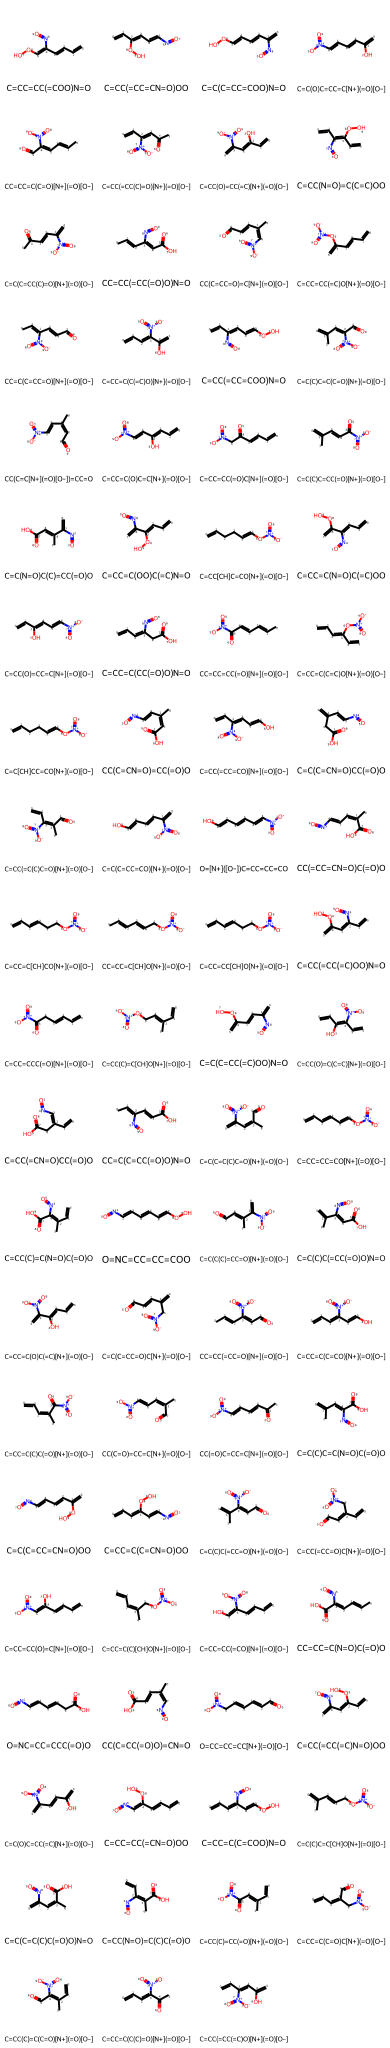

In [53]:
# --- Display molecules matching a specific Excel row if needed---
print(matching_rows)
# Specify the index of the Excel row
excel_row_index_to_display = int(input("Select the index of the Excel row to display: "))

# Get the list of matching SMILES for this row
smiles_for_this_row = matching_smiles_by_excel_row.get(excel_row_index_to_display, [])

if smiles_for_this_row:
    print(f"Displaying molecules matching Excel row index: {excel_row_index_to_display}")
    print(f"Found {len(smiles_for_this_row)} matching simulated product(s) for this row.")
    mols_to_draw = [Chem.MolFromSmiles(smi) for smi in smiles_for_this_row if Chem.MolFromSmiles(smi) is not None]
    legends_to_draw = [smi for smi in smiles_for_this_row if Chem.MolFromSmiles(smi) is not None]

    # Draw if there are valid molecules
    if mols_to_draw:
        img = Draw.MolsToGridImage(mols_to_draw, molsPerRow=4, subImgSize=(100, 100),
                                 legends=legends_to_draw,
                                 maxMols=len(mols_to_draw), useSVG=True)
        display(img)
    else:
        print("No valid molecules found for this row after filtering.")
else:
    print(f"No matching molecules found for Excel row index: {excel_row_index_to_display}")


**8. Possible pathways and energy calculations for a pecific matching compound in a specific matching row**


Excel rows with matching compounds:
[0, 1, 2, 6, 15, 16, 20, 21, 27, 30, 32, 37, 39, 40, 42, 52, 55, 58, 64, 65, 70, 79, 90, 91, 102, 114, 117, 126, 127, 130, 139, 140, 144, 148, 150, 151, 161, 165, 169, 173, 186, 188, 193, 199, 208, 210, 214, 215, 233, 234, 235, 237, 239, 248, 276, 280, 290, 295, 305, 318, 323, 330, 335, 361, 363, 366, 370, 373, 378, 379, 380, 383, 386, 387, 389, 395, 400, 403, 404, 410, 446, 451, 461, 462, 465, 471, 491, 508, 512, 521, 525, 533, 538, 553, 556, 564, 570, 573, 575]
Enter the Excel row index to trace pathways for: 575

Found 83 matching simulated product(s) for Excel row index 575.

Clustering 83 matching compounds with cutoff 0.5...
Clustering resulted in 31 representative compound(s).

Representative compounds after clustering:
1: C=C(C(C)=CC=O)[N+](=O)[O-]
2: C=CC=C(C(=C)O)[N+](=O)[O-]
3: C=CC=CC(=CO)[N+](=O)[O-]
4: C=CC=C(O)C=C[N+](=O)[O-]
5: C=CC=C(C)C(=O)[N+](=O)[O-]
6: CC(C=C[N+](=O)[O-])=CC=O
7: C=CC(=CC=CN=O)OO
8: CC=CC=C[CH]O[N+](=O)[O-]
9: C

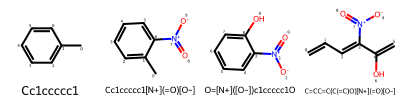

------------------------------
--- Pathway 2 ---
Step 0: Initial reactant: Cc1ccccc1
Step 1: Reactant: Cc1ccccc1 --(Rule 24)--> Product: Oc1ccccc1
Step 2: Reactant: Oc1ccccc1 --(Rule 1)--> Product: O=[N+]([O-])c1ccccc1O
Step 3: Reactant: O=[N+]([O-])c1ccccc1O --(Rule 8)--> Product: C=CC=C(C(=C)O)[N+](=O)[O-]


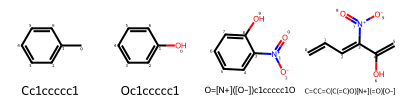

------------------------------
--- Pathway 3 ---
Step 0: Initial reactant: Cc1ccccc1
Step 1: Reactant: Cc1ccccc1 --(Rule 0)--> Product: Cc1ccccc1O
Step 2: Reactant: Cc1ccccc1O --(Rule 8)--> Product: C=CC=C(C)C(=C)O
Step 3: Reactant: C=CC=C(C)C(=C)O --(Rule 12)--> Product: C=CC=C(C(=C)O)[N+](=O)[O-]


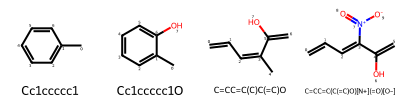

------------------------------
--- Pathway 4 ---
Step 0: Initial reactant: Cc1ccccc1
Step 1: Reactant: Cc1ccccc1 --(Rule 1)--> Product: Cc1ccccc1[N+](=O)[O-]
Step 2: Reactant: Cc1ccccc1[N+](=O)[O-] --(Rule 8)--> Product: C=CC=C(C(=C)C)[N+](=O)[O-]
Step 3: Reactant: C=CC=C(C(=C)C)[N+](=O)[O-] --(Rule 24)--> Product: C=CC=C(C(=C)O)[N+](=O)[O-]


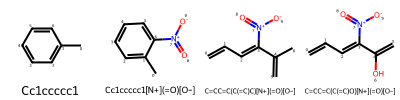

------------------------------
Enter the index of the pathway to use for DFT calculation (1 to 4): 4
Pathway 4 selected for DFT preparation.

Preparing molecules from the selected pathway for DFT calculation: 
Processing 4 molecule(s) from the selected pathway for DFT.
Molecule: Cc1ccccc1
saved to file:Iso_pathway_row_575_mol_1.xyz
Molecule: Cc1ccccc1[N+](=O)[O-]
saved to file:Iso_pathway_row_575_mol_2.xyz
Molecule: C=CC=C(C(=C)C)[N+](=O)[O-]
saved to file:Iso_pathway_row_575_mol_3.xyz
Molecule: C=CC=C(C(=C)O)[N+](=O)[O-]
saved to file:Iso_pathway_row_575_mol_4.xyz


In [17]:
# Define a cutoff for clustering the matching compounds for a specific row
clustering_cutoff_pathway = 0.5

# Get the list of Excel row indices that have matching compounds
matching_rows = sorted(list(matching_smiles_by_excel_row.keys()))

if not matching_rows:
    print("No Excel rows had matching generated compounds.")
else:
    print("\nExcel rows with matching compounds:")
    print(matching_rows)

    try:
        selected_row_index = int(input(f"Enter the Excel row index to trace pathways for: "))

        # Check if the entered row index is in the list of rows that had matches
        if selected_row_index not in matching_rows:
            print(f"Error: Row index {selected_row_index} did not have any matching compounds.")
        else:
            # Get the list of simulated SMILES that matched this specific Excel row
            smiles_for_row_all = matching_smiles_by_excel_row.get(selected_row_index, [])

            # Check if there are any matching simulated products for this row
            if not smiles_for_row_all:
                 print(f"Error: No matching simulated smiles found for Excel row index: {selected_row_index}")
            else:
                print(f"\nFound {len(smiles_for_row_all)} matching simulated product(s) for Excel row index {selected_row_index}.")

                # --- Perform Clustering on the matching compounds for this row ---
                print(f"\nClustering {len(smiles_for_row_all)} matching compounds with cutoff {clustering_cutoff_pathway}...")
                mols_to_cluster = [Chem.MolFromSmiles(smi) for smi in smiles_for_row_all if Chem.MolFromSmiles(smi) is not None]

                if len(mols_to_cluster) == 0:
                    print("No valid molecules to cluster for this row after RDKit parsing.")
                    representative_smiles = []
                else:
                    representative_mols = cluster_and_filter(mols_to_cluster, clustering_cutoff_pathway)
                    representative_smiles = [Chem.MolToSmiles(mol) for mol in representative_mols]

                    print(f"Clustering resulted in {len(representative_smiles)} representative compound(s).")

                # --- Trace Pathways for Representative Compounds ---
                all_representative_pathways = {} # Dictionary to store pathways for each representative

                if not representative_smiles:
                    print("No representative compounds found after clustering to trace pathways for.")
                else:
                    print("\nRepresentative compounds after clustering:")
                    for i, smiles in enumerate(representative_smiles):
                        print(f"{i+1}: {smiles}")

                    # Select which representative SMILES to trace pathways for
                    representative_smiles_index_input = input(f"Select the number of the representative compound to trace pathways for (1 to {len(representative_smiles)}): ")

                    try:
                        representative_smiles_index_to_trace = int(representative_smiles_index_input) - 1

                        # Check if the entered index for representative SMILES selection is valid
                        if 0 <= representative_smiles_index_to_trace < len(representative_smiles):
                            product_smiles_to_trace = representative_smiles[representative_smiles_index_to_trace]

                            print(f"\nTracing ALL pathways for representative SMILES: {product_smiles_to_trace}")

                            # Trace ALL unique pathways leading to the selected representative product
                            traced_pathways = trace_reaction_path_all(product_smiles_to_trace, reaction_history)

                            # Check if any pathways were found
                            if traced_pathways:
                                print(f"Found {len(traced_pathways)} unique pathway(s):")

                                # Temporarily store the SMILES sequences of the displayed pathways for selection
                                displayed_pathways = []

                                # Iterate through each found pathway to display it
                                for path_index, pathway in enumerate(traced_pathways):
                                    print(f"--- Pathway {path_index + 1} ---")

                                    pathway_molecules = []
                                    legends = []
                                    current_pathway_smiles = []

                                    # Get the initial reactant from the first step of the pathway
                                    initial_reactant_smi = pathway[0][0] if pathway else None
                                    # If the initial reactant is valid, add it to the lists for display and storage
                                    if initial_reactant_smi and Chem.MolFromSmiles(initial_reactant_smi) is not None:
                                         pathway_molecules.append(Chem.MolFromSmiles(initial_reactant_smi))
                                         legends.append(initial_reactant_smi)
                                         current_pathway_smiles.append(initial_reactant_smi)
                                         print(f"Step 0: Initial reactant: {initial_reactant_smi}")
                                    else:
                                         print(f"Warning: Initial reactant '{initial_reactant_smi}' in pathway {path_index + 1} is not a valid molecule and will not be displayed.")


                                    # Iterate through each step in the current pathway
                                    for j, step in enumerate(pathway):
                                        reactant, rxn_index, product, is_match = step
                                        product_mol = Chem.MolFromSmiles(product)

                                        # Check if the product molecule was successfully created and add it
                                        if product_mol is not None:
                                            # Check to avoid duplicates in drawing
                                            if product not in legends:
                                                 pathway_molecules.append(Chem.MolFromSmiles(product))
                                                 legends.append(product)
                                            current_pathway_smiles.append(product)
                                            print(f"Step {j+1}: Reactant: {reactant} --(Rule {rxn_index})--> Product: {product}")
                                        else:
                                             print(f"Warning: Product '{product}' from step {j+1} in pathway {path_index + 1} is not a valid molecule and will not be displayed.")


                                    # If there are molecules to display in this pathway
                                    if pathway_molecules:
                                        try:
                                            img = Draw.MolsToGridImage(pathway_molecules, molsPerRow=min(len(pathway_molecules), 6),
                                                                       subImgSize=(100, 100), legends=legends, maxMols=len(pathway_molecules), useSVG=True)
                                            display(img)
                                        except Exception as e:
                                            print(f"Error generating image for pathway {path_index + 1}: {e}")
                                    else:
                                        print(f"No valid molecules to display for pathway {path_index + 1}.")


                                    print("-" * 30)
                                    # Store the list of SMILES for the current pathway
                                    displayed_pathways.append(current_pathway_smiles)


                                # ----------- Pathway Selection for DFT -------------#
                                while True:
                                     # Select one of the displayed pathways by index for DFT calculation
                                    pathway_selection_input = input(f"Enter the index of the pathway to use for DFT calculation (1 to {len(displayed_pathways)}): ")
                                    try:
                                         selected_pathway_index = int(pathway_selection_input) - 1
                                         # Check if the entered pathway index is valid
                                         if 0 <= selected_pathway_index < len(displayed_pathways):
                                             # Retrieve the list of SMILES for the selected pathway
                                             selected_pathway_smiles = displayed_pathways[selected_pathway_index]
                                             print(f"Pathway {selected_pathway_index + 1} selected for DFT preparation.")
                                             break
                                         else:
                                             print(f"Invalid pathway index. Please enter a number between 1 and {len(displayed_pathways)}.")
                                    except ValueError:
                                         print("Invalid input. Please enter an integer.")

                                print("=" * 40)

                            else:
                                 print(f"No pathways found for representative product {product_smiles_to_trace}")

                        else:
                             print(f"Error. Please enter a number between 1 and {len(representative_smiles)}.")

                    except ValueError:
                         print("Error. Please enter a number.")


    except ValueError:
        print("Invalid input for Excel row index. Please enter an integer.")


#----- DFT calculation -----#

print("\nPreparing molecules from the selected pathway for DFT calculation: ")

# Displaying atom indices
IPythonConsole.drawOptions.addAtomIndices = True

# Prefix for the file name
prefix = "Iso_"

# Check if a pathway was successfully selected and has SMILES
if 'selected_pathway_smiles' in locals() and selected_pathway_smiles:
    smiles_list_for_dft = selected_pathway_smiles
    print(f"Processing {len(smiles_list_for_dft)} molecule(s) from the selected pathway for DFT.")

    # Iterate through the SMILES strings in the selected pathway
    for i, smi in enumerate(smiles_list_for_dft):
      mol = Chem.MolFromSmiles(smi)
      if mol is None:
          print(f"Could not parse SMILES from selected pathway: {smi}. Skipping DFT prep for this molecule.")
          continue

      mol = Chem.AddHs(mol)

      # Attempt to generate a 3D conformation for the molecule
      try:
          Chem.AllChem.EmbedMolecule(mol)
          if mol.GetNumAtoms() >= 2 and mol.GetNumConformers() > 0:
               pass

      except Exception as e:
          # Handle potential errors during 3D embedding
          print(f"Could not generate 3D conformation for {smi} (from selected pathway): {e}. Skipping 3D processing for DFT prep.")
          # Display the 2D representation if 3D failed
          display(mol)
          continue

      # Save the molecule's 3D coordinates to an XYZ file
      filename = f"{prefix}pathway_row_{selected_row_index}_mol_{i+1}.xyz"
      try:
          Chem.MolToXYZFile(mol, filename)
      except Exception as e:
          print(f"Could not save XYZ file for {smi}: {e}")
          display(mol)
          continue

      # Information about the processed molecule
      print(f"Molecule: {smi}")
      print(f"saved to file:{filename}")
      # Display the 2D representation of the molecule
      #display(mol)

else:
    print("No pathway was selected or the selected pathway was empty. DFT preparation skipped.")

**DFT Calculation**

In [18]:
filenames = [f"{prefix}pathway_row_{selected_row_index}_mol_{i+1}.xyz" for i in range(len(smiles_list_for_dft))]

print("\nStarting DFT calculations...")

dft_results = {}

for i, smi in enumerate(smiles_list_for_dft):
    filename = f"{prefix}pathway_row_{selected_row_index}_mol_{i+1}.xyz"

    print(f"\nProcessing Molecule {i+1}: SMILES: {smi}")

    mol_rdkit = Chem.MolFromSmiles(smi)

    if mol_rdkit is None:
        print(f"  Skipping DFT: Could not parse SMILES {smi} into an RDKit molecule.")
        dft_results[smi] = "Skipped: Invalid SMILES"
        continue

    # Add explicit hydrogen atoms
    mol_rdkit = Chem.AddHs(mol_rdkit)

    # Attempt to generate a 3D conformation and optimize it
    try:
        # Try ETKDGv2 for conformer generation
        params = AllChem.ETKDGv2()
        params.randomSeed = 42 # for reproducibility
        conf_id = AllChem.EmbedMolecule(mol_rdkit, params)

        if conf_id < 0:
            print(f"  Skipping DFT: Could not generate initial 3D conformation for {smi}.")
            dft_results[smi] = "Skipped: No Initial 3D Conformation"
            display(mol_rdkit)
            continue

        # Check if MMFF force field can be applied
        try:
            if AllChem.MMFFOptimizeMolecule(mol_rdkit) == 0:
                 print("  Molecular mechanics optimization converged.")
            else:
                 print("  Molecular mechanics optimization did not converge.")
        except Exception as mmff_e:
             print(f"  Molecular mechanics optimization failed: {mmff_e}")

    except Exception as e:
        print(f"  Skipping DFT: Error during 3D embedding or MM optimization for {smi}: {e}")
        dft_results[smi] = f"Skipped: 3D/MM Error ({e})"
        display(mol_rdkit)
        continue

    # Save the molecule's 3D coordinates to an XYZ file AFTER optimization
    try:
        Chem.MolToXYZFile(mol_rdkit, filename)
        print(f"  Saved 3D coordinates to {filename}")
    except Exception as e:
        print(f"  Skipping DFT: Could not save XYZ file for {smi}: {e}")
        dft_results[smi] = f"Skipped: XYZ Save Error ({e})"
        display(mol_rdkit)
        continue

    # --- Pyscf Calculation ---
    try:
        # Determine charge and spin from RDKit molecule
        mol_charge = Chem.GetFormalCharge(mol_rdkit)
        num_electrons_neutral = sum(atom.GetAtomicNum() for atom in mol_rdkit.GetAtoms())
        num_electrons_actual = num_electrons_neutral - mol_charge
        spin_state_2S = num_electrons_actual % 2
        multiplicity = spin_state_2S + 1

        with open(filename, 'r') as f:
            atom_coords = f.read().splitlines()[2:]

        # Build pyscf molecule object
        mol_pyscf = gto.M(atom=atom_coords, basis='sto-3g', unit='Angstrom',
                          spin=spin_state_2S,
                          charge=mol_charge)

        # Setup and run SCF calculation
        if spin_state_2S == 0:
             mf = scf.RKS(mol_pyscf)
             print("  Using Restricted Kohn-Sham (RKS)...")
        else:
             mf = scf.UKS(mol_pyscf)
             print("  Using Unrestricted Kohn-Sham (UKS)...")

        mf.xc = 'b3lyp'

        energy = mf.kernel()

        if mf.converged:
            print(f"  DFT Calculation Converged. Energy: {energy:.15f}")
            dft_results[smi] = energy
        else:
            print(f"  Skipping DFT: SCF calculation did NOT converge for {smi}. Final energy: {energy:.15f}")
            dft_results[smi] = f"Skipped: SCF Not Converged (Final E: {energy:.15f})"


    except FileNotFoundError:
         print(f"  Skipping DFT: XYZ file not found {filename}. This should not happen if file save succeeded.")
         dft_results[smi] = "Skipped: XYZ file missing unexpectedly"
    except Exception as e:
         print(f"  Skipping DFT: An error occurred during pyscf calculation for {smi}: {e}")
         dft_results[smi] = f"Skipped: Pyscf Error ({e})"

print("\n--- DFT Calculation Summary ---")
for smi, result in dft_results.items():
    if isinstance(result, float):
        print(f"SMILES: {smi}, Energy (Hartree): {result:.15f}")
    else:
        print(f"SMILES: {smi}, Status: {result}")


Starting DFT calculations...

Processing Molecule 1: SMILES: Cc1ccccc1
  Molecular mechanics optimization converged.
  Saved 3D coordinates to Iso_pathway_row_575_mol_1.xyz
  Using Restricted Kohn-Sham (RKS)...
converged SCF energy = -268.257488539071
  DFT Calculation Converged. Energy: -268.257488539071119

Processing Molecule 2: SMILES: Cc1ccccc1[N+](=O)[O-]
  Molecular mechanics optimization converged.
  Saved 3D coordinates to Iso_pathway_row_575_mol_2.xyz
  Using Restricted Kohn-Sham (RKS)...
converged SCF energy = -469.90376847058
  DFT Calculation Converged. Energy: -469.903768470580133

Processing Molecule 3: SMILES: C=CC=C(C(=C)C)[N+](=O)[O-]
  Molecular mechanics optimization converged.
  Saved 3D coordinates to Iso_pathway_row_575_mol_3.xyz
  Using Restricted Kohn-Sham (RKS)...
converged SCF energy = -471.022175507662
  DFT Calculation Converged. Energy: -471.022175507662382

Processing Molecule 4: SMILES: C=CC=C(C(=C)O)[N+](=O)[O-]
  Molecular mechanics optimization conve

**9. Ranking reaction rules**

In [34]:
all_known_matching_smiles = set()
for smiles_list in matching_smiles_by_excel_row.values():
    for smiles in smiles_list:
        all_known_matching_smiles.add(smiles)

# Total number of unique known matching smiles
total_unique_known_matching_smiles = len(all_known_matching_smiles)

print(f"Total unique known matching smiles: {total_unique_known_matching_smiles}")

rule_contributions_known = {}
for reactant_smiles, rxn_index, product_smiles, is_match in reaction_history:
  if rxn_index != -1 and product_smiles in all_known_matching_smiles:
      # Use setdefault to initialize if rule_index not present
      rule_contributions_known.setdefault(rxn_index, {'total_known_matches': 0, 'unique_known_matching_products': set()})
      rule_contributions_known[rxn_index]['total_known_matches'] += 1
      # Add the product SMILES to the set of unique matches for this rule
      rule_contributions_known[rxn_index]['unique_known_matching_products'].add(product_smiles)

ranked_rules = sorted(rule_contributions_known.items(),
                            key=lambda item: (len(item[1]['unique_known_matching_products']) / total_unique_known_matching_smiles * 100) if total_unique_known_matching_smiles > 0 else 0,
                            reverse=True)

# Ranked rules
for rxn_index, stats in ranked_rules:
  percentage_contribution = (len(stats['unique_known_matching_products']) / total_unique_known_matching_smiles * 100) if total_unique_known_matching_smiles > 0 else 0
  print(f"Rule {rxn_index}: Contribution Score = {percentage_contribution:.2f}%" )

Total unique known matching smiles: 3864
Rule 23: Contribution Score = 21.45%
Rule 15: Contribution Score = 16.02%
Rule 12: Contribution Score = 13.90%
Rule 1: Contribution Score = 13.59%
Rule 6: Contribution Score = 13.22%
Rule 8: Contribution Score = 13.20%
Rule 2: Contribution Score = 11.57%
Rule 0: Contribution Score = 11.28%
Rule 3: Contribution Score = 10.74%
Rule 13: Contribution Score = 9.58%
Rule 16: Contribution Score = 9.21%
Rule 11: Contribution Score = 7.32%
Rule 20: Contribution Score = 5.80%
Rule 14: Contribution Score = 5.36%
Rule 5: Contribution Score = 5.07%
Rule 24: Contribution Score = 3.18%
Rule 9: Contribution Score = 2.95%
Rule 7: Contribution Score = 2.85%
Rule 19: Contribution Score = 2.48%
Rule 10: Contribution Score = 2.33%
Rule 22: Contribution Score = 2.20%
Rule 4: Contribution Score = 1.79%
Rule 17: Contribution Score = 1.01%
Rule 18: Contribution Score = 0.41%
Rule 21: Contribution Score = 0.08%
Rule 28: Contribution Score = 0.03%
Rule 26: Contribution Sc

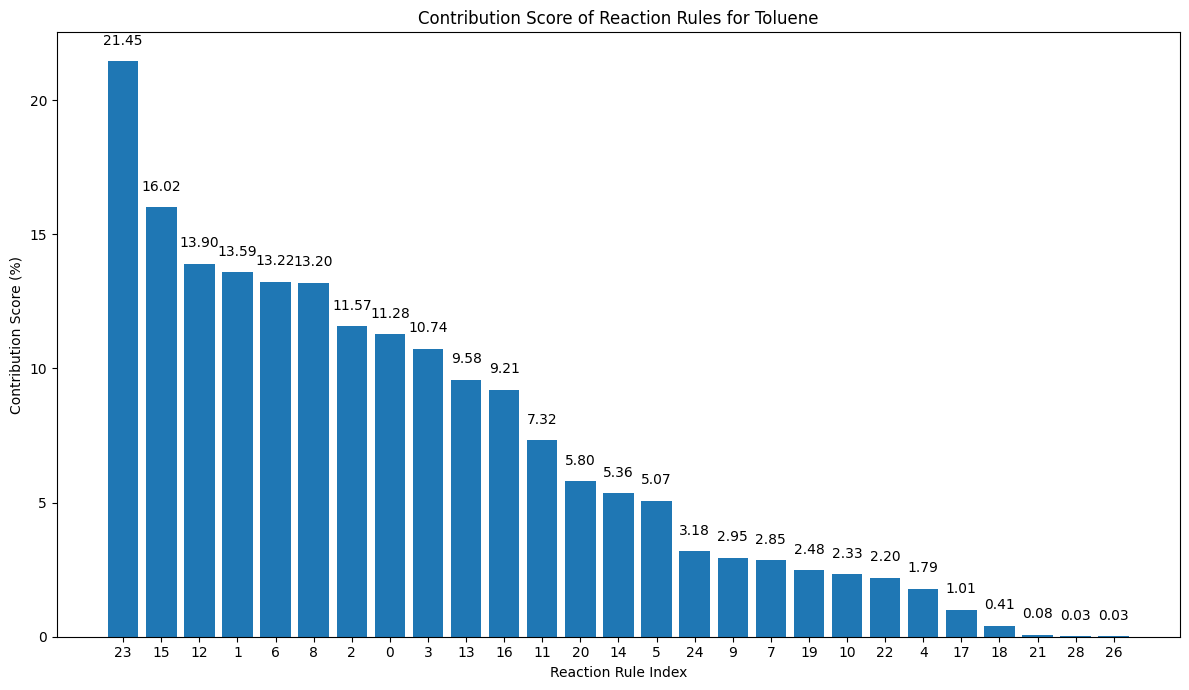

In [83]:
# Plotting the ranked rules
rule_indices = [item[0] for item in ranked_rules]
contribution_scores = [
    (len(stats['unique_known_matching_products']) / total_unique_known_matching_smiles * 100) if total_unique_known_matching_smiles > 0 else 0
    for rxn_index, stats in ranked_rules
]

plt.figure(figsize=(12, 7))
bars = plt.bar(range(len(rule_indices)), contribution_scores, tick_label=rule_indices)
plt.xlabel("Reaction Rule Index")
plt.ylabel("Contribution Score (%)")
plt.title("Contribution Score of Reaction Rules for Toluene")
plt.xticks(rotation=0)

# Add the contribution score values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()